# 개요

## 서론
재원이는 축구를 좋아한다. 평소에도 FIFA 게임을 즐기고 있으며, 최근 개최된 2018 러시아 월드컵에도 큰 관심을 가지고 관람했다.  
뿐만 아니라 해외축구까지도 섭렵하며 유러피안 리그도 그의 큰 관심사 중 하나이다.  
평소 축구는 좋아하지만 베팅에는 큰 관심이 없던 재원이도 이번 월드컵에서 배당률이 5000 이상 뛰는 걸 보고 호기심이 생겼다.  
베팅 사이트를 들어가보니 각 경기마다 배당률이 매겨지는데, 많은 축구 팬들이 베팅을 했기 때문인지 배당률만 봐도 어느정도 판세가 보임을 알 수 있었다.  
그래서 굳이 베팅을 하지는 않더라도, 미리 경기의 결과를 예측함에 있어서 의미있는 요인이라는 생각이 들었다.
하지만 단순히 배당률만 보고 그대로 따라간다면 예측의 의미가 있을까?  
그래서 문득 데이터 분석을 배운 김에 승부 예측을 향상시킬 방법을 찾아보기로 결심했다!  

## 분석 대상
1. 업체신뢰도: 베팅업체 배당률과 실제 예측성공률을 비교
2. 배당률 패턴(승:무:패 / 비슷함, 승쏠림, 패쏠림, 무쏠림)에 따라서 실제 결과가 어떻게 나오는지 분석해보기
3. 팀별 상성
4. 매치데이터를 통한 팀 성향 분류 및 상성 분석

## 결론
기본적으로 베팅업체의 배당률만 봐도 대략적으로 경기 결과(승/무/패)를 예측할 수 있다.
따라서 (홈팀을 기준으로) 승(W), 무(D), 패(L)의 확률을 계산해볼 수 있다.

>P(W) = a
P(D) = b
P(L) = c
; a+b+c = 1

다만 배당률만 보고 가기엔 너무나 도박적이기 때문에 *배당률 패턴, 팀별 상성, 팀 성향 상성* 등의 요인을 추가하여 확률을 보정하고싶다.
식을 보정하는 방법은 나중에 생각해보자.

# 업체신뢰도
일단 1x2 betting odds를 기준으로 분석을 해보자.  
그리고 업체 신뢰도를 판단하기에 앞서 업체의 수가 너무 많은 관계로 필터링을 거쳐보자.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df1718 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1718/E0.csv", sep=',', header = 0)
df1617 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv", sep=',', header = 0)
df1516 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1516/E0.csv", sep=',', header = 0)
df = pd.concat([df1718,df1617,df1516], ignore_index = True)


다음과 같이 B365, BW 두 업체의 배당률을 통해 비교해보자.

In [3]:
B365_odds = ['B365H', 'B365D', 'B365A']
BW_odds = ['BWH', 'BWD', 'BWA']
df[['FTR']+B365_odds + BW_odds].head()

,FTR,B365H,B365D,B365A,BWH,BWD,BWA
0,H,1.53,4.5,6.50,1.50,4.60,6.75
1,A,11.00,5.5,1.33,11.00,5.25,1.30
2,A,1.25,6.5,15.00,1.22,6.50,12.50
3,A,1.83,3.6,5.00,1.80,3.50,4.75
4,H,1.70,3.8,5.75,1.70,3.60,5.50


예상대로, 5경기뿐이지만 두 업체모두 배당률은 비슷한 패턴을 보인다.
또한 실제로 배당(수치)이 제일 작은 결과가 실제 결과와 일치하는 것을 볼 수 있다.  
그렇다면 먼저 간단하게 다음을 살펴보자.
> 업체 예측 결과가 실제 결과가 같을 확률  
; 업체 예측 결과 = 배당률이 가장 낮은 결과


In [4]:
# 값이 최소인 라벨을 구해서 그 라벨의 맨 끝자리[-1]를 보면 H/D/A로 예측 값을 알수있고, 그걸 실제 결과인 FTR 과 비교하자!!!

bookmakers = ['B365', 'IW', 'LB', 'PS', 'WH', 'VC']    # BW 는 918 행에 NaN이 들어가서 뺐다.
results = ['H', 'D', 'A']

for bookmaker in bookmakers:
    cases = [bookmaker+result for result in results]
    guess = df[cases].idxmin(axis=1).map(lambda x: x[-1])
    df[bookmaker] = (df['FTR']==guess)
    
hit_rate = df[bookmakers].apply(pd.value_counts)
hit_rate.loc['Hit rate'] = hit_rate.loc[True] / hit_rate.sum()
hit_rate

,B365,IW,LB,PS,WH,VC
True,622.000000,624.000000,623.000000,621.000000,619.000000,621.000000
False,518.000000,516.000000,517.000000,519.000000,521.000000,519.000000
Hit rate,0.545614,0.547368,0.546491,0.544737,0.542982,0.544737


미미한 차이가 있기는 하지만
> 전체적으로 최소 배당을 통한 승/무/패 결과 예측은...  
 *"배당업체에 따른 차이가 없어보인다."*
 
평균적으로 54.5% 정도의 예측 성공률을 나타내고 있는데, 이 정도면 실제 결과 예측과 충분한 관계성이 보인다.
자칫 경기 결과를 승/패 2가지 경우로 오해할 수 있는데, 어디까지나 이 베팅은 승/무/패 3가지 경우를 예측한 것이다.
따라서 아무 기반도 없다면 33%에 그쳐버리는 예측 성공률을 54.5%까지는 올릴 수 있었다.  

하지만 아직 이 정도 수치로는 부족하다. 의미있는 예측을 하기 위해 다른 관점에서 분석해보도록 하자.

단순히 승/무/패 예측이 성공했냐로 끝나지 않고,
> 승/무/패 배당률에 비례해서 배당업체가 얼마나 강하게 예측했고 성공률이 어떤지를 나타내는 지표를 분석해보자.



odd = certainty(1.0) / probability = 1/선택한 결과가 나올 확률
<=> 선택한 결과가 나올 확률 = 1 / 소수점 배당률(odd)

>홈이 이길 확률     = P(H) = 1 / odd['H']  
비길 확률          = P(D) = 1 / odd['D']  
어웨이가 이길 확률 = P(A) = 1 / odd['A']

그런데 베팅업체는 수익을 위해 마진을 설정하기 때문에 위의 식을 그대로 적용하면 확률의 총합이 1보다 커진다.
즉 1보다 큰 부분은 마진에 의해 발생한 오차이므로, 확률의 총합이 1이 되도록 처리한다.

>sum = P(H) + P(D) + P(A)  (margin = sum - 1)  
1 = (P(H) + P(D) + P(A)) / sum = P(H)/sum + P(D)/sum + P(A)/sum


In [5]:
for bookmaker in bookmakers:
    cases = [bookmaker+result for result in results]
    probs = df[cases].apply(lambda x: 1/x)
    with_margin = probs.sum(axis=1)
    df[[case+'P' for case in cases]] = probs.apply(lambda x: x/with_margin)
    print(df[[case+'P' for case in cases]].head())
    

     B365HP    B365DP    B365AP
0  0.634766  0.215820  0.149414
1  0.088726  0.177452  0.733823
2  0.783920  0.150754  0.065327
3  0.533523  0.271208  0.195269
4  0.573717  0.256663  0.169621
       IWHP      IWDP      IWAP
0  0.643989  0.210370  0.145641
1  0.118549  0.178941  0.702510
2  0.776914  0.152877  0.070210
3  0.510516  0.269844  0.219640
4  0.555722  0.255332  0.188946
       LBHP      LBDP      LBAP
0  0.645656  0.211306  0.143038
1  0.093525  0.187050  0.719424
2  0.768802  0.167131  0.064067
3  0.520639  0.275632  0.203728
4  0.561172  0.260322  0.178506
       PSHP      PSDP      PSAP
0  0.641181  0.215606  0.143213
1  0.089729  0.177034  0.733237
2  0.779652  0.155930  0.064417
3  0.534961  0.273458  0.191581
4  0.575883  0.255614  0.168503
       WHHP      WHDP      WHAP
0  0.617556  0.224967  0.157477
1  0.094321  0.196501  0.709178
2  0.755614  0.171731  0.072655
3  0.524809  0.286260  0.188931
4  0.557164  0.270622  0.172214
       VCHP      VCDP      VCAP
0  0.634

위와 같이 각 업체별로 총합이 1이 되는 확률을 계산했다.  
위의 확률만 보고 결과를 예측하는 것은 이미 위에서 했던대로 배당률만 보고 판단하는 것과 같다.  
이미 이것만으로도 약 21.5%라는 확률의 비약적인 상승을 얻었다.  
하지만 배당률도 결국 인간인 베팅 이용자에 의해 결정되는 것이므로 완벽하지 않다.  
이제는 배당률 이외의 데이터를 분석해서 확률을 조정하고, 더 좋은 예측 성공률을 얻어보자.  

이전의 분석에 의하면 경기 결과와 상관도(correlation)이 높은 요인은 다음과 같다.  
홈일 경우, 배당률을 제외하면 다음의 요인들이 있다.
- 양의 관계 : FTHG, HTHG, HS, HST
- 음의 관계 : FTAG, HTAG, AS, AST  

안타깝게도 다른 변수들은 큰 상관성을 보여주지 않았다.  
그래도 다음과 같이 여러 관점에서 시도해볼 수 있다.
- 상대 팀과의 관계 고려(아예 한 팀만의 데이터를 볼지, 다른 팀과의 경기라는 조건 하에서 볼지)
- 지난 경기 중 일부만 고려(옛날 데이터를 제외하거나 x 0.01(forget) 등을 해서 영향력을 줄이더라도 포함시킬지)

    
현재로서는 다음과 같이 고려해볼만한 요인을 정해보았다.

- 경기 결과에 의한 승률  

    1. 최근 N경기 내의 전적에 의한 승률 (팀 고려x)
    2. 최근 N경기 내의 상대전적에 의한 승률 (해당 팀간의 전적)  
    3. 홈에 강한 팀과 어웨이에 강한 팀
      
- 매치 데이터에 의한 승률

    4. (최근 N경기 내의) 평균(또는 다른 형태로) 유효슈팅 수에 의한 승률  
    5. (최근 N경기 내의) (유효)슈팅을 기준으로 상대적인 공격/수비성을 비교하고 그에 따른 우위 분석 후 반영
      ex) 양 팀의 최근 (유효)슈팅 횟수 동향이 많이 유사하다면 승/패가 아닌 무의 결과가 나올 확률 상승
      
- 배당률 패턴에 의한 확률

    6. 배당률이 (H, D, A) 중 한쪽에 쏠린 경우 또는 배당률 간의 차이가 작을 경우 등의 패턴별로 결과를 분석

## 전적에 의한 승률

일단 상대 팀, 홈/어웨이 등은 고려하지 않고 단순 승률을 구해보자.


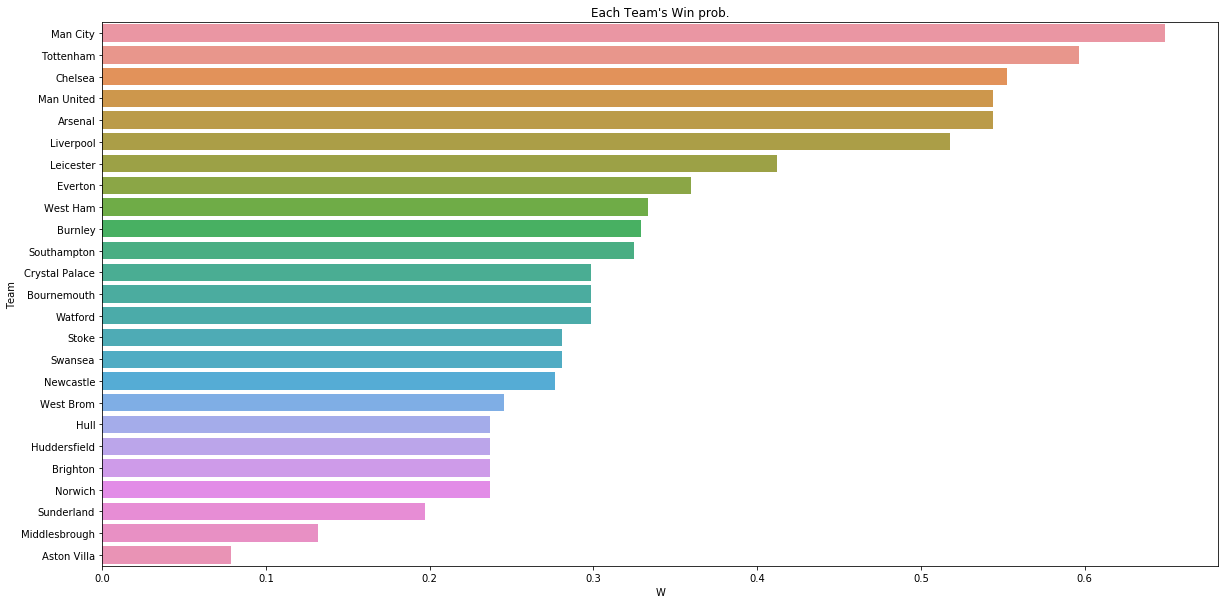

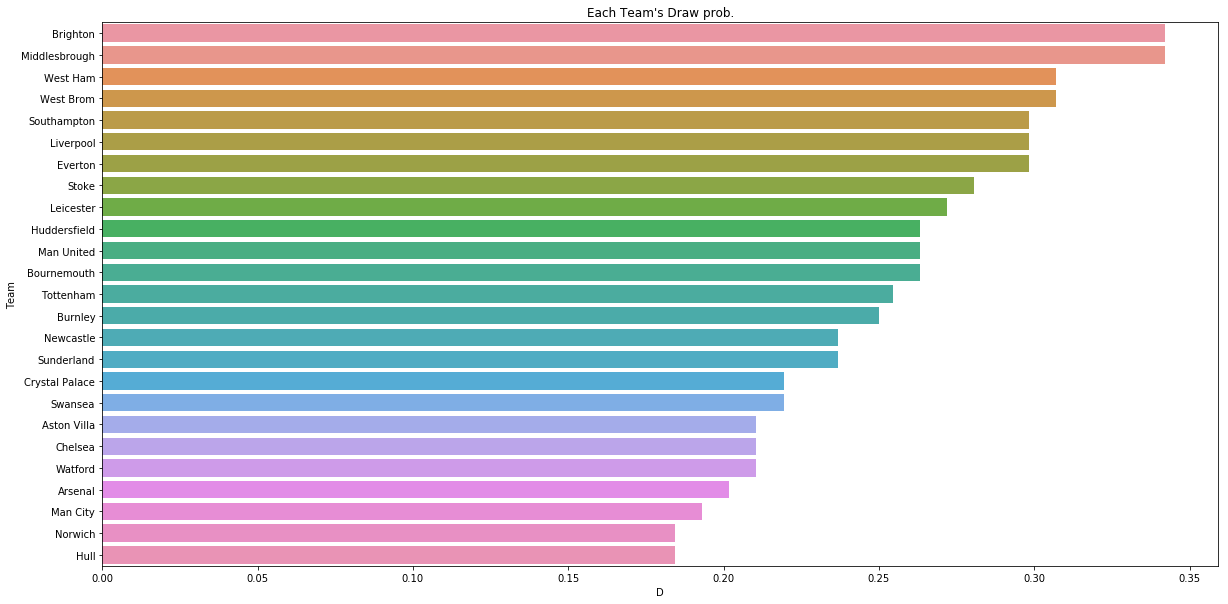

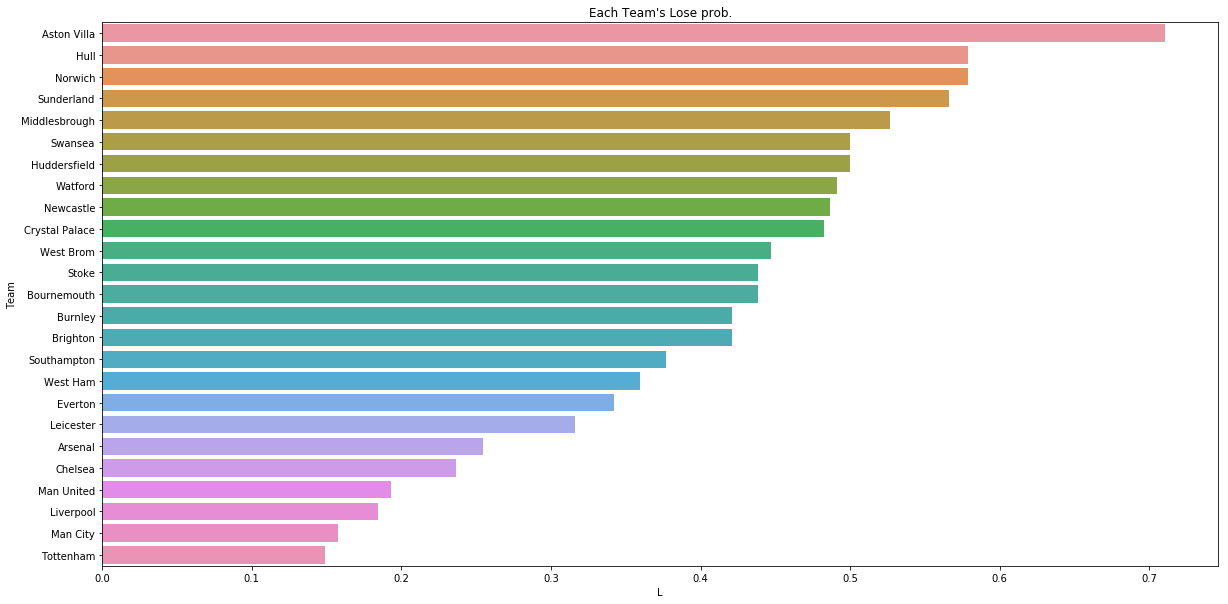

In [6]:
match_data = ['HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HTW', 'HTD', 'HTL']
df["HTW"] = (df["FTHG"] > df["FTAG"]).astype(int)
df["HTD"] = (df["FTHG"] == df["FTAG"]).astype(int)
df["HTL"] = (df["FTHG"] < df["FTAG"]).astype(int)
df_match = df[match_data]
ht_prob = df_match.groupby('HomeTeam')

ht_prob = ht_prob['HTW', 'HTD', 'HTL'].count() * ht_prob['HTW', 'HTD', 'HTL'].mean()
ht_prob.columns = ['W', 'D', 'L']
ht_prob.index.name = 'Team'
at_prob = df_match.groupby('AwayTeam')
at_prob = at_prob['HTW', 'HTD', 'HTL'].count() * at_prob['HTW', 'HTD', 'HTL'].mean()
at_prob.columns = ['L', 'D', 'W']
at_prob.index.name = 'Team'

history_prob = pd.DataFrame(data=(ht_prob + at_prob), columns=['W', 'D', 'L'])
history_prob['sum'] = history_prob.sum(axis=1)
history_prob['W']/=history_prob['sum']
history_prob['D']/=history_prob['sum']
history_prob['L']/=history_prob['sum']

plt.figure(figsize=(20,10))
sns.barplot(y='Team', x='W', data=history_prob.reset_index().sort_values(by='W', ascending=False)).set_title('Each Team\'s Win prob.')
plt.show()

plt.figure(figsize=(20,10))
sns.barplot(y='Team', x='D', data=history_prob.reset_index().sort_values(by='D', ascending=False)).set_title('Each Team\'s Draw prob.')
plt.show()

plt.figure(figsize=(20,10))
sns.barplot(y='Team', x='L', data=history_prob.reset_index().sort_values(by='L', ascending=False)).set_title('Each Team\'s Lose prob.')
plt.show()

간략하게 봤을때, 맨시티가 눈에 띄게 선두를 달리고 있고, 그와 대조되는 Aston Villa는 승률과 패율 모두 압도적인 모습을 보인다.  
하지만 단순히 순위를 나열하는 행위에서는 특별한 의미를 찾지 못했다.  
이제는 계산한 각 결과의 확률을 처음에 구했던 배당에 의한 확률을 조정해보자.  
가장 간단한 방법은 average(배당확률, 전적승률)으로 조정하는 것이다. 바로 해보자.  

업체별로 큰차이는 없는 걸로 보이지만, 그 중에서 가장 예측 성공률이 높은 **IW**(약 54.7%)로 해보자.

df에서 IWHP, IWDP, IWAP는 확률을 이미 구해놨다.  
매 경기를 의미하는 각 행에는 홈팀과 어웨이팀의 이름이 있다.  
그 이름에 맞는 history_prob.loc['name']을 조회하면 W, D, L로 승/무/패 확률을 조회할 수 있다.
>df['HHP'] = mean(df['IWHP'], history_prob.loc['HomeTeam']['W'], history_prob.loc['AwayTeam']['L'])  
df['HDP'] = mean(df['IWDP'], history_prob.loc['HomeTeam']['D'], history_prob.loc['AwayTeam']['D'])  
df['HAP'] = mean(df['IWAP'], history_prob.loc['HomeTeam']['L'], history_prob.loc['AwayTeam']['W'])

위와 같이 History based Probability를 구해보자.

In [15]:
history_prob['Arsenal']

,W,D,L,sum
Team,,,,
Arsenal,0.543860,0.201754,0.254386,114.0
Aston Villa,0.078947,0.210526,0.710526,38.0
Bournemouth,0.298246,0.263158,0.438596,114.0
Brighton,0.236842,0.342105,0.421053,38.0
Burnley,0.328947,0.250000,0.421053,76.0
Chelsea,0.552632,0.210526,0.236842,114.0
Crystal Palace,0.298246,0.219298,0.482456,114.0
Everton,0.359649,0.298246,0.342105,114.0
Huddersfield,0.236842,0.263158,0.500000,38.0


history 확률이 적용된 H(H/D/A)P를 구했다면, In[3]과 같이 hit_rate를 구할 수 있다!  
어서 구해보고 기존의 hit_rate에 비해 개선되는지 확인해보자.

In [56]:
hp_dict_w = history_prob['W'].T.to_dict()
hp_dict_d = history_prob['D'].T.to_dict()
hp_dict_l = history_prob['L'].T.to_dict()

df['HHP'] = (df['IWHP']+df['HomeTeam'].map(hp_dict_w)+df['AwayTeam'].map(hp_dict_l))/3
df['HDP'] = (df['IWDP']+df['HomeTeam'].map(hp_dict_d)+df['AwayTeam'].map(hp_dict_d))/3
df['HAP'] = (df['IWAP']+df['HomeTeam'].map(hp_dict_l)+df['AwayTeam'].map(hp_dict_w))/3

df[['HomeTeam','AwayTeam','HHP','HDP','HAP']].head()

,HomeTeam,AwayTeam,HHP,HDP,HAP
0,Arsenal,Leicester,0.501213,0.228018,0.270769
1,Brighton,Man City,0.171095,0.238010,0.590895
2,Chelsea,Burnley,0.583533,0.204468,0.212000
3,Crystal Palace,Huddersfield,0.436254,0.250767,0.312980
4,Everton,Stoke,0.451323,0.278093,0.270584
